In [2]:
import os
import h5py
import json
import keras
import random 
import imageio
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import backend as K
from datetime import timedelta
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [3]:
Data = pd.read_csv('DsDnsPrScTch.csv') 

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
Data["Teacher First Project Posted Date"]=pd.to_datetime(Data["Teacher First Project Posted Date"])
Data["Project Fully Funded Date"]=pd.to_datetime(Data["Project Fully Funded Date"])
Data["Project Expiration Date"]=pd.to_datetime(Data["Project Expiration Date"])
Data["Project Posted Date"]=pd.to_datetime(Data["Project Posted Date"])
Data["Donation Received Date"]=pd.to_datetime(Data["Donation Received Date"])
Data["Number of dates since posted"]=Data.loc[:,"Donation Received Date"]-Data.loc[:,"Project Posted Date"]
Data.head()

,Unnamed: 0,Project ID,Donation ID,Donor ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,Donation Received Date,Donor City,Donor State,...,School Metro Type,School Percentage Free Lunch,School State,School Zip,School City,School County,School District,Teacher Prefix,Teacher First Project Posted Date,Number of dates since posted
0,0,000009891526c0ade7180f8423792063,688729120858666221208529ee3fc18e,1f4b5b6e68445c6c4a0509b3aca93f38,No,178.37,11,2016-08-23 13:15:57,West Jordan,Utah,...,suburban,23.0,Utah,84065.0,Riverton,Salt Lake,Jordan School District,Mr.,2015-09-19,102 days 13:15:57
1,1,000009891526c0ade7180f8423792063,dcf1071da3aa3561f91ac689d1f73dee,4aaab6d244bf3599682239ed5591af8a,Yes,25.00,2,2016-06-06 20:05:23,Riverton,Utah,...,suburban,23.0,Utah,84065.0,Riverton,Salt Lake,Jordan School District,Mr.,2015-09-19,24 days 20:05:23
2,2,000009891526c0ade7180f8423792063,18a234b9d1e538c431761d521ea7799d,0b0765dc9c759adc48a07688ba25e94e,Yes,20.00,3,2016-06-06 14:08:46,Riverton,Utah,...,suburban,23.0,Utah,84065.0,Riverton,Salt Lake,Jordan School District,Mr.,2015-09-19,24 days 14:08:46
3,3,000009891526c0ade7180f8423792063,38d2744bf9138b0b57ed581c76c0e2da,377944ad61f72d800b25ec1862aec363,Yes,25.00,1,2016-05-15 10:23:04,Phoenix,Arizona,...,suburban,23.0,Utah,84065.0,Riverton,Salt Lake,Jordan School District,Mr.,2015-09-19,2 days 10:23:04
4,4,000009891526c0ade7180f8423792063,5a032791e31167a70206bfb86fb60035,6d5b22d39e68c656071a842732c63a0c,Yes,25.00,2,2016-05-17 01:23:38,Salt Lake City,Utah,...,suburban,23.0,Utah,84065.0,Riverton,Salt Lake,Jordan School District,Mr.,2015-09-19,4 days 01:23:38


In [5]:
Data.dtypes

Unnamed: 0                                       int64
Project ID                                      object
Donation ID                                     object
Donor ID                                        object
Donation Included Optional Donation             object
Donation Amount                                float64
Donor Cart Sequence                              int64
Donation Received Date                  datetime64[ns]
Donor City                                      object
Donor State                                     object
Donor Is Teacher                                object
Donor Zip                                       object
School ID                                       object
Teacher ID                                      object
Teacher Project Posted Sequence                  int64
Project Type                                    object
Project Title                                   object
Project Essay                                   object
Project Sh

In [6]:
Data["Number of dates since posted"]=Data["Number of dates since posted"]/ np.timedelta64(1, 'D')

MaxT=max(Data["Project Posted Date"])
MinT=min(Data["Project Posted Date"])

In [7]:
print("MaxT :",MaxT,"\t\t","MinT :",MinT)

MaxT : 2018-05-01 00:00:00 		 MinT : 2013-01-01 00:00:00


In [8]:
T= datetime.date(2013, 1, 1)+timedelta(days=14)


In [9]:
T

datetime.date(2013, 1, 15)

In [10]:
Model_variables = ["Project Cost","Number of dates since posted"]

In [27]:
clf = LogisticRegression(random_state=9)

T_current=MinT-timedelta(days=28)+timedelta(days=120)    
T_period=3 #timedelta(days=28)    
acc=[]
T=[]
sub_var=set(["Project ID","Project Posted Date","Project Expiration Date","Donation Received Date",
         "Project Cost","Donation Amount","Number of dates since posted"])

sub_var.union(set(Model_variables))
sub_Data =Data.loc[:,list(sub_var)]

while (T_current<MaxT-timedelta(days=30)):

    T_current = T_current+timedelta(days=28)   
    T+=[T_current]
    T_Train_start = T_current-timedelta(days=120)
    T_Train_end = T_current-timedelta(days=30)
    
    C_Data = sub_Data[sub_Data["Project Posted Date"] < pd.to_datetime(T_current)]
    C_Data = C_Data[C_Data["Project Posted Date"] > pd.to_datetime(T_Train_start)]
    C_Data = C_Data[C_Data["Number of dates since posted"] < T_period]
    C_Data["Fund_Ratio_30"]=C_Data["Donation Amount"]/C_Data["Project Cost"]
    
    
    Train_Data = C_Data[sub_Data["Project Posted Date"] < pd.to_datetime(T_Train_end)]
    Train_Data_CR=Train_Data.groupby(["Project ID"]).sum()
    Train_Data_Final=Train_Data.groupby(["Project ID"]).max()
    Train_Data_Final["Fund_Ratio_30"]=Train_Data_CR["Fund_Ratio_30"]
    Train_Data_Final["Donation Amount"]=Train_Data_CR["Donation Amount"]
    Train_Data_Final['Label'] = Train_Data_Final.apply(lambda x : 1 if x['Fund_Ratio_30'] < 0.5  else 0, axis=1)
    
    Train_Data_Final.rename(columns = {'Donation Received Date':'Last Donation Received Date'})

    
    Test_Data = C_Data[sub_Data["Project Posted Date"] >= pd.to_datetime(T_Train_end)]
    Test_Data_CR=Test_Data.groupby(["Project ID"]).sum()
    Test_Data_Final=Test_Data.groupby(["Project ID"]).max()
    Test_Data_Final["Fund_Ratio_30"]=Test_Data_CR["Fund_Ratio_30"]
    Test_Data_Final["Donation Amount"]=Test_Data_CR["Donation Amount"]
    Test_Data_Final['Label'] = Test_Data_Final.apply(lambda x : 1 if x['Fund_Ratio_30'] < 0.5  else 0, axis=1)
    Test_Data_Final=Test_Data_Final.rename(columns = {'Donation Received Date':'Last Donation Received Date'})
    
    X_train = Train_Data_Final.loc[:,Model_variables]
    X_train.head()
    Y_train =  Train_Data_Final.loc[:,["Label"]]
    Y_train

    X_test = Test_Data_Final.loc[:,Model_variables]
    X_test.head()
    Y_test =  Test_Data_Final.loc[:,["Label"]]
    Y_test
    
    
    
    clf.fit(X_train, Y_train)

    Y_pred_train_prob = clf.predict_proba(X_train)[:,1]
    Y_pred_test = clf.predict(X_test)
    Y_pred_test_prob = clf.predict_proba(X_test)[:,1]
    Test_Data_Final["Y_pred_test"]=Y_pred_test_prob
    
    cm= confusion_matrix(Y_test,Y_pred_test)
    TN, FP ,FN, TP =  cm.ravel()
    test_score=(TP+TN)/(TN+ FP +FN+ TP)
    acc+=[test_score]
    print(T_current,"\t","Training Shape: ",Train_Data.shape,"\t\t","Testing Shape: ",Test_Data.shape)
    print('LogisticRegression Testing Accuracy = ',test_score,"\n")
    print("\tTP:",TP,"\tFP:",FP,"\n\tTN:",TN,"\tFN:",FN )
    print("\n"*2)
    break
    
    


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2013-05-01 00:00:00 	 Training Shape:  (52645, 8) 		 Testing Shape:  (12911, 8)
LogisticRegression Testing Accuracy =  0.8919237902545945 

	TP: 5280 	FP: 623 
	TN: 10 	FN: 18





In [33]:
Test_Data_Final=Test_Data_Final.sort_values(by=['Y_pred_test'], ascending=False)
Test_Data_Final.head(20)

,Project Posted Date,Project Cost,Number of dates since posted,Last Donation Received Date,Project Expiration Date,Donation Amount,Fund_Ratio_30,Label,Y_pred_test
Project ID,,,,,,,,,
8c88fe4f090a656861616dfed49ec116,2013-04-16,111596.67,2.588646,2013-04-18 14:07:39,2013-08-15,6595.00,0.059097,1,1.000000
7aed27c695e3376612bc2da11c3c94a5,2013-04-19,9158.05,0.000000,2013-04-19 00:00:00,2013-08-16,0.00,0.000000,1,1.000000
981167d431c1a0dd258407365fef3360,2013-04-20,8578.26,0.000000,2013-04-20 00:00:00,2013-08-17,0.00,0.000000,1,1.000000
a7ca1d6c15ba85ecd794c03cd2447640,2013-04-25,7795.86,0.000000,2013-04-25 00:00:00,2013-08-24,0.00,0.000000,1,1.000000
0fdc191a4f039f0eca903e6e800d7f5c,2013-04-27,7423.33,0.000000,2013-04-27 00:00:00,2013-08-25,0.00,0.000000,1,1.000000
bb83b13fd6b98519c986ac67a6c14546,2013-04-30,7028.76,0.000000,2013-04-30 00:00:00,2013-08-29,0.00,0.000000,1,0.999999
46a58fc7fd8b0f7daf318f8568e1973d,2013-04-21,6615.69,0.000000,2013-04-21 00:00:00,2013-08-16,0.00,0.000000,1,0.999999
d15b7a244f980c19e47ee1f139dfcbe5,2013-04-15,6482.04,0.000000,2013-04-15 00:00:00,2013-08-08,0.00,0.000000,1,0.999998
e14179eb6a9aa5ffee151a897cf4b8ae,2013-04-05,6444.12,0.000000,2013-04-05 00:00:00,2013-06-06,0.00,0.000000,1,0.999998


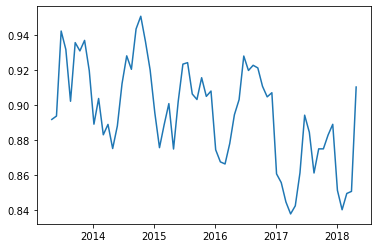

In [19]:
plt.plot(T,acc)

As of Date: 2018-04-25 00:00:00


['Label', 'Project Cost', 'Number of dates since posted']

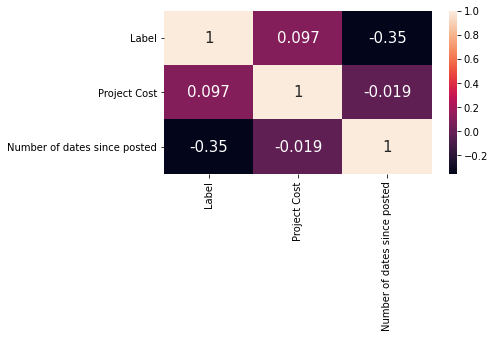

In [22]:
print("As of Date:",T_current)
X_train = Train_Data_Final.loc[:,Model_variables]
X_train.head()
Y_train =  Train_Data_Final.loc[:,["Label"]]
Y_train

X_test = Test_Data_Final.loc[:,Model_variables]
X_test.head()
Y_test =  Test_Data_Final.loc[:,["Label"]]
Y_test

from pandas import DataFrame
import seaborn as sn
highCo=["Label"]+Model_variables
df = DataFrame(Train_Data_Final,columns=highCo)
fig, ax = plt.subplots(figsize=(6,3),sharex=True, sharey=True) 
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True,annot_kws={"size": 15},ax=ax)
highCo

In [13]:
clf = LogisticRegression(random_state=9)
clf.fit(X_train, Y_train)

Y_pred_prob = clf.predict_proba(X_train)[:,1]
Y_pred_test = clf.predict(X_test)


cm= confusion_matrix(Y_test,Y_pred_test)
#Extract  TN, FP ,FN, TP
TN, FP ,FN, TP =  cm.ravel()

test_score=(TP+TN)/(TN+ FP +FN+ TP)
#print(cm)
print('LogisticRegression Testing Accuracy = ',test_score,"\n")
print("\tTP:",TP,"\tFP:",FP,"\n\tTN:",TN,"\tFN:",FN )
print("\n"*2)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression Testing Accuracy =  0.9104391009778657 

	TP: 52799 	FP: 4100 
	TN: 550 	FN: 1148





In [14]:
def Train_model(model,X_train,Y_train):
    model.fit(X_train, Y_train)
    return model